In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
import seaborn as sns
import modules_TFM as mod
import random as rd

from scipy.optimize import curve_fit
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

In [3]:
full_data=pd.read_hdf('C:/Users/pablo/OneDrive - Universidade de Santiago de Compostela/Máster/TFM/ldc1_merged.h5')

Impongo ciertas condiciones a los datos. $S1e_{min}=5pes$ y estar lejos del cátodo y del ánodo

In [5]:
real_data=full_data[(full_data.DT>0) & (full_data.DT<1150) & (full_data.S1e>5)]

Hago un colormap de todos los datos que estan en ese rango para S2w y DT

(5.0, 45.0)

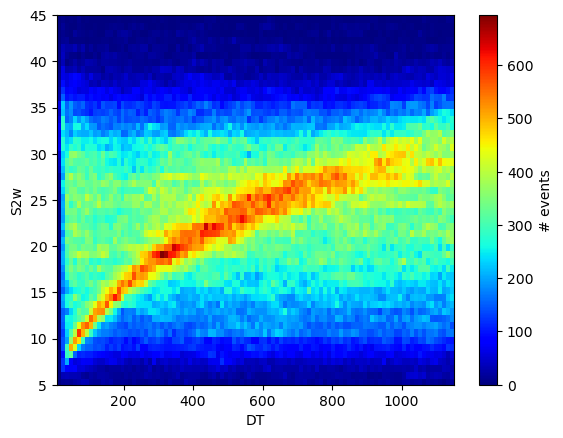

In [7]:
plt.hist2d(real_data.DT,real_data.S2w,bins=100,cmap='jet');
plt.colorbar(label='# events')
plt.xlabel('DT')
plt.ylabel('S2w')
plt.ylim(5,45)

Defino los cortes que me dan los datos 'limpios'

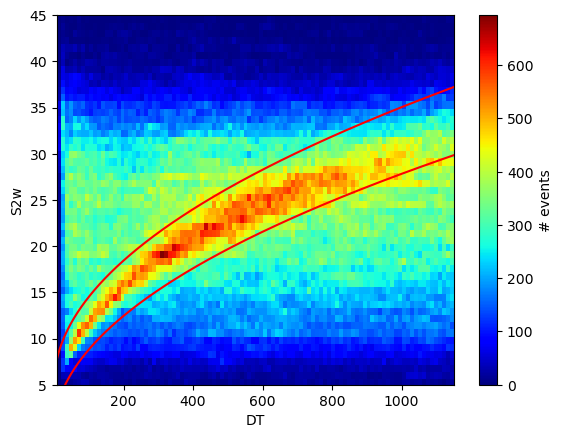

In [9]:
f= lambda x,a,b: a+b*x**0.5
f1 = lambda x: f(x,5,.95)
f2 = lambda x: f(x,0,0.88)

plt.hist2d(real_data.DT,real_data.S2w,bins=100,cmap='jet');
plt.colorbar(label='# events')
plt.xlabel('DT')
plt.ylabel('S2w')
plt.ylim(5,45)

x=np.linspace(0, max(real_data.DT),len(real_data.S2w))
plt.plot(x,f1(x), color='red')
plt.plot(x,f2(x), color='red')  

Hago subdatasets con los valores dentro y fuera del corte en cada caso.

In [11]:
DT_raw=real_data.DT
s2w_raw=real_data.S2w
mask=(s2w_raw<f1(DT_raw))&(s2w_raw>f2(DT_raw))
inverse_mask=~mask

dst_in=real_data[mask]
dst_out=real_data[inverse_mask & (DT_raw>0)]

In [12]:
def recompute_npeaks(df):
    events= df.groupby('event')
    ns1= events.s1_peak.nunique().values
    ns2= events.s2_peak.nunique().values
    n = events.s1_peak.count ().values
    df.loc[:, 'nS1'] = np.repeat(ns1,n) 
    df.loc[:, 'nS2']= np.repeat(ns2,n)
    return df

La función de arriba es la de Gonzalo, la idea es que la primera línea selecciona todos los eventos de forma que los cambios que se hagan en cada row afectan a todas la columnas menos a la de eventos. Agrupa el número de picos de s1 y s2 diferentes y luego cuenta el numero total de picos. Recalcula recalcula el numero de S1 y S2 que hay en cada evento

Ahora grafico los eventos que hay dentro de la banda seleccionada.

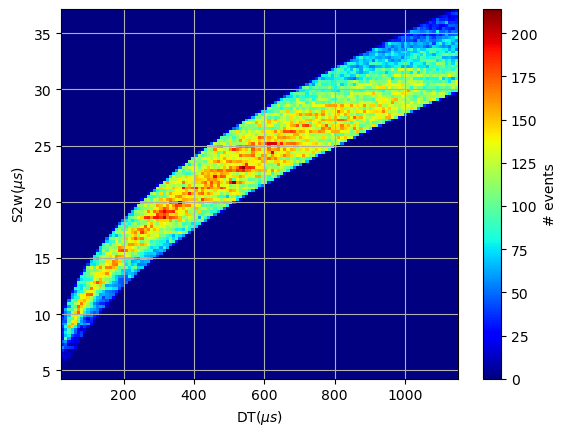

In [15]:
d2hist=plt.hist2d(dst_in.DT, dst_in.S2w, bins=125, cmap='jet')
plt.colorbar(label='# events')
plt.xlabel(r'DT($\mu s$)')
plt.ylabel(r'S2w($\mu s$)')
plt.grid()

Busco entrenar las predicciones con estos datos de la banda:

In [17]:
dt_predictors_more_1S1=mod.DT_predictor(dst_in.S2w, dst_in.DT , n_bins=30, threshold=1)

In [18]:
dt_predicted_more_1S1=dt_predictors_more_1S1(dst_in.S2w)

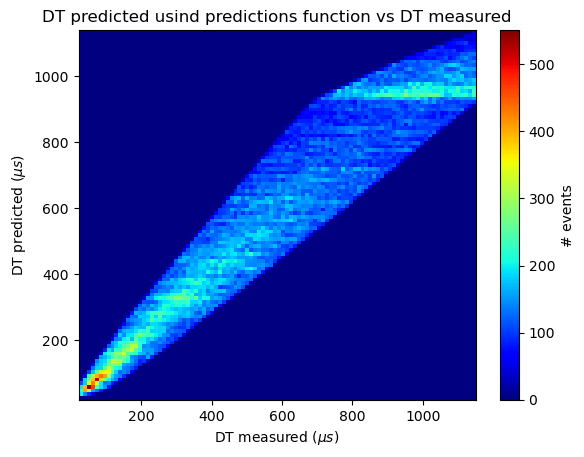

In [19]:
plt.hist2d(dst_in.DT, dt_predicted_more_1S1[0], bins=100, cmap='jet');
plt.xlabel(r'DT measured ($\mu s$)')
plt.ylabel(r'DT predicted $(\mu s)$')
plt.title(r'DT predicted usind predictions function vs DT measured')
plt.colorbar(label='# events')

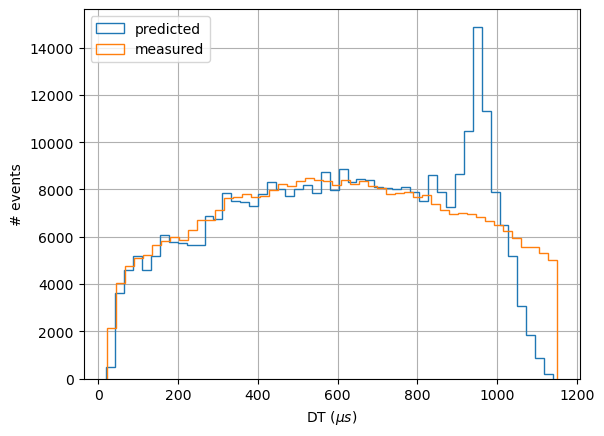

In [20]:
plt.hist(dt_predicted_more_1S1[0], bins=50, label='predicted', histtype='step');
plt.hist(dst_in.DT, bins=50, label='measured', histtype='step');
plt.legend()
plt.xlabel(r'DT $(\mu s)$')
plt.ylabel('# events')
plt.grid(True)

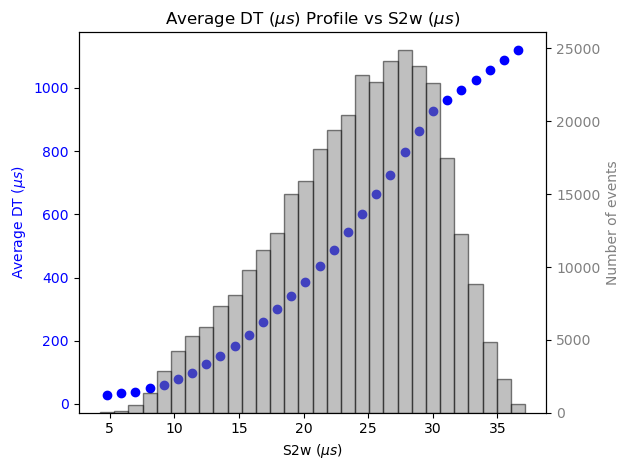

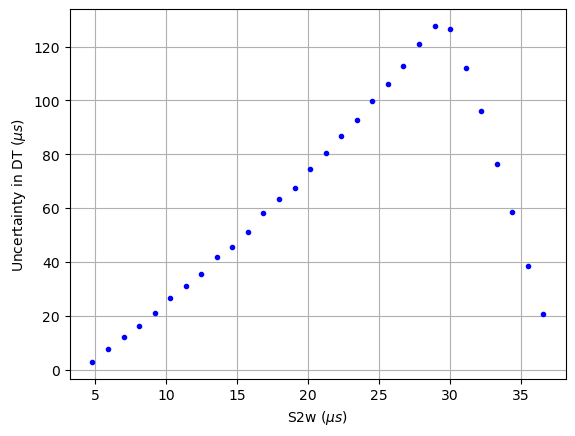

In [21]:
mod.profiles(dst_in.S2w, dst_in.DT, n_bins=30, threshold=1, plot=True, x_label=r'S2w ($\mu s$)', y_label=r'DT ($\mu s$)');

### Tratamos de mejorar la función de predicción con eventos con solo un S1

In [23]:
dst_inr=recompute_npeaks(dst_in)
dst_in1S1=dst_inr[dst_inr.nS1==1]

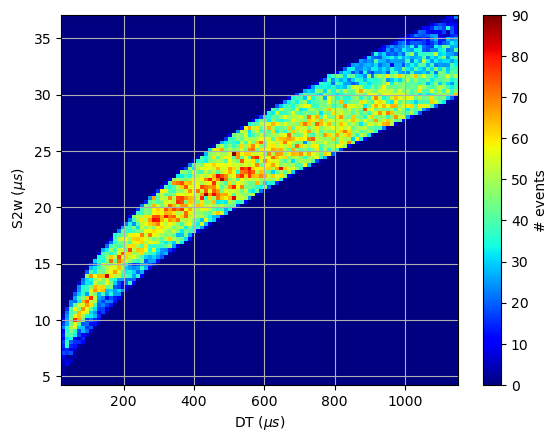

In [24]:
plt.hist2d(dst_in1S1.DT, dst_in1S1.S2w, bins=100, cmap='jet');
plt.xlabel(r'DT $(\mu s)$')
plt.ylabel(r' S2w $(\mu s)$')
plt.colorbar(label=r'# events')
plt.grid()

In [25]:
dt_predictor_1s1=mod.DT_predictor(dst_in1S1.S2w, dst_in1S1.DT, threshold=1, n_bins=30)
dt_predicted_1s1=dt_predictor_1s1(dst_in1S1.S2w)

Text(0.5, 1.0, 'DT predicted usind predictions function 1 S1 vs DT measured')

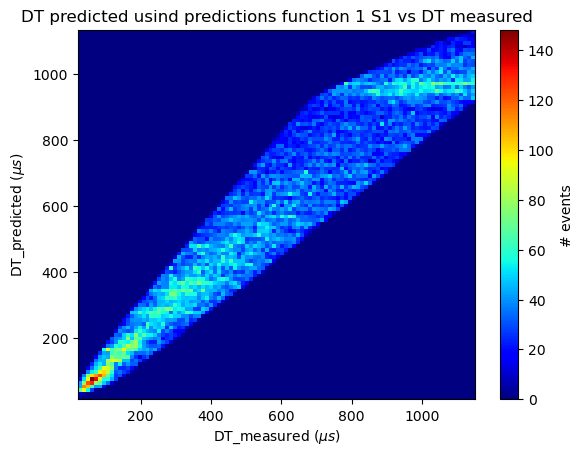

In [26]:
plt.hist2d(dst_in1S1.DT, dt_predicted_1s1[0], bins=100, cmap='jet');
plt.xlabel(r'DT_measured $(\mu s)$')
plt.ylabel(r'DT_predicted $(\mu s)$')
plt.colorbar(label='# events')
plt.title(r'DT predicted usind predictions function 1 S1 vs DT measured')

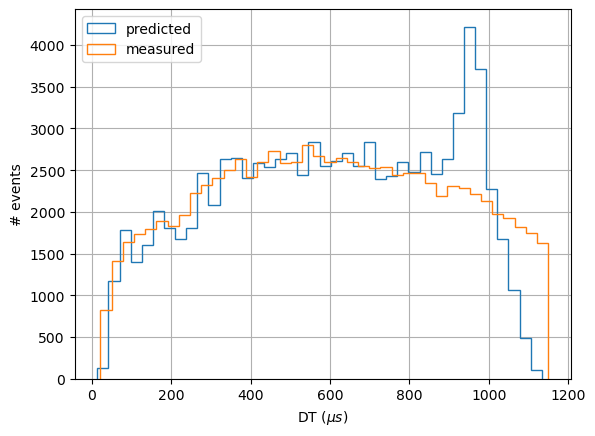

In [27]:
plt.hist(dt_predicted_1s1[0], bins=40, label='predicted', histtype='step');
plt.hist(dst_in1S1.DT, bins=40, label='measured', histtype='step');
plt.legend()
plt.xlabel(r'DT $(\mu s)$')
plt.ylabel('# events')
plt.grid(True)

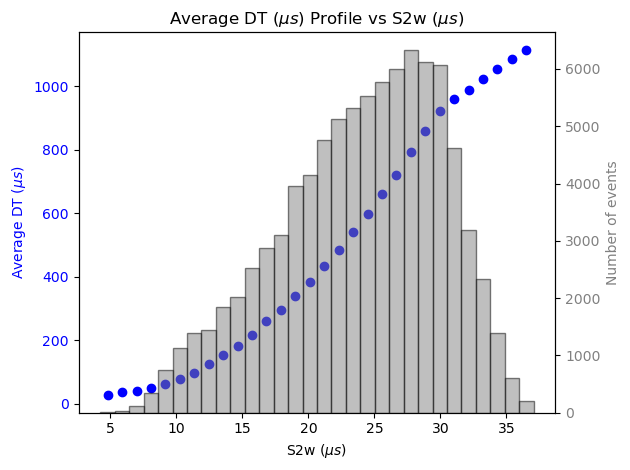

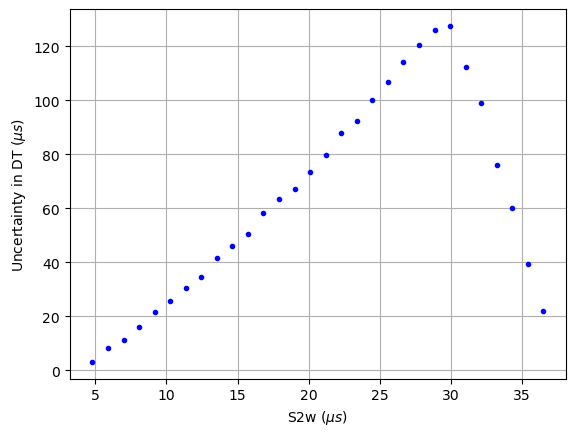

In [28]:
mod.profiles(dst_in1S1.S2w, dst_in1S1.DT, n_bins=30, threshold=1, plot=True, x_label=r'S2w ($\mu s$)', y_label=r'DT ($\mu s$)');

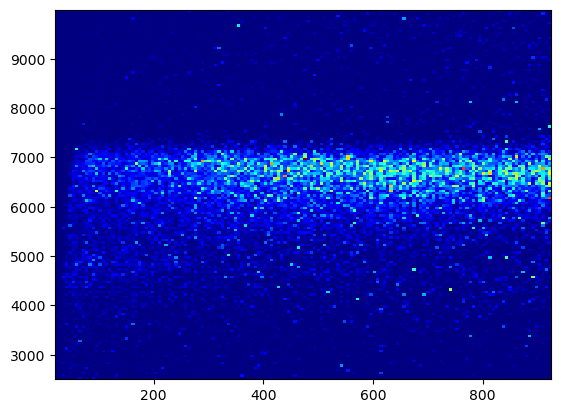

In [29]:
plt.hist2d(dt_predictors_more_1S1((dst_in1S1.S2w[dst_in1S1.S2w<30]))[0],dst_in1S1.S2e[dst_in1S1.S2w<30], bins=150, cmap='jet');

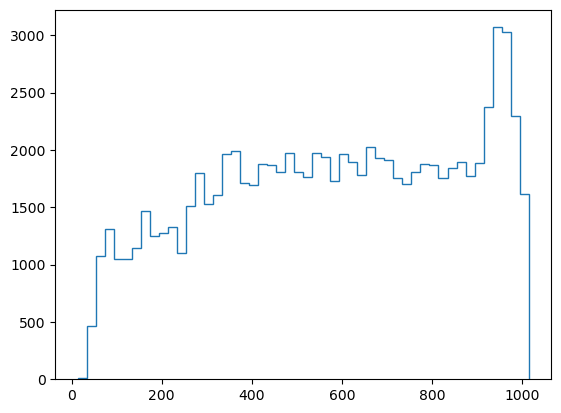

In [30]:
plt.hist(dt_predictor_1s1(dst_in1S1.S2w[dst_in1S1.S2w<33])[0], bins=50, histtype='step');

In [31]:
def exponential(x,mu,E0):
    return E0*np.exp(-x/mu)

popt,pcov=curve_fit(exponential, dt_predictor_1s1(dst_in.S2w[dst_in.DT<700])[0], dst_in.S2e[dst_in.DT<700],p0=[1200,7000])

In [32]:
popt

array([1.74982386e+10, 6.25824217e+03])

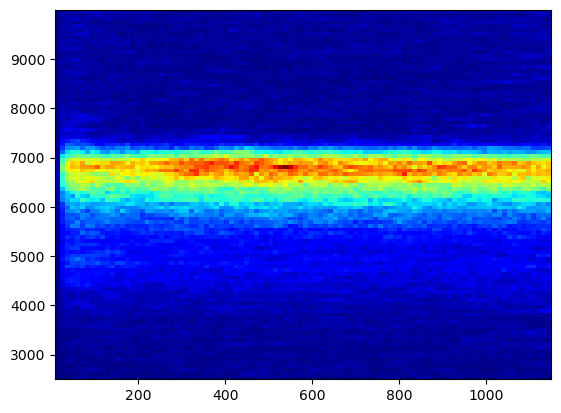

In [33]:
plt.hist2d(real_data.DT, real_data.S2e, bins=100, cmap='jet');

In [34]:
popt,pcov=curve_fit(exponential,real_data.DT, real_data.S2e ,p0=[1200,7000])

In [35]:
popt


array([2.06570699e+09, 6.32461048e+03])

In [36]:
dt_predictor_1s1_cut=mod.DT_predictor(dst_in1S1.S2w[dst_in1S1.S2w<30], dst_in1S1.DT[dst_in1S1.S2w<30], threshold=1, n_bins=30)
dt_predicted_1s1_cut=dt_predictor_1s1(dst_in1S1.S2w[dst_in1S1.S2w<30])

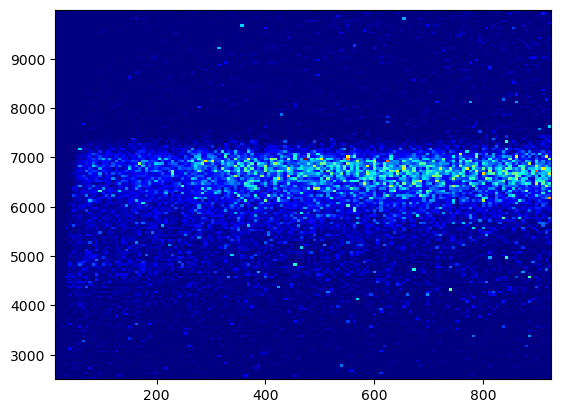

In [37]:
plt.hist2d(dt_predicted_1s1_cut[0],dst_in1S1.S2e[dst_in1S1.S2w<30], bins=150, cmap='jet');

In [38]:
popt,pcov=curve_fit(exponential,dt_predicted_1s1_cut[0], dst_in1S1.S2e[dst_in1S1.S2w<30] ,p0=[1200,7000])

In [39]:
popt

array([1.77719680e+10, 6.30310436e+03])

### Parámetros de difusión

Tomamos los eventos dentro de la ventana, con el corte a 5 pes, lejos del ánodo para no ver efectos de alphas y busco que solo haya una S1 y una S2. 

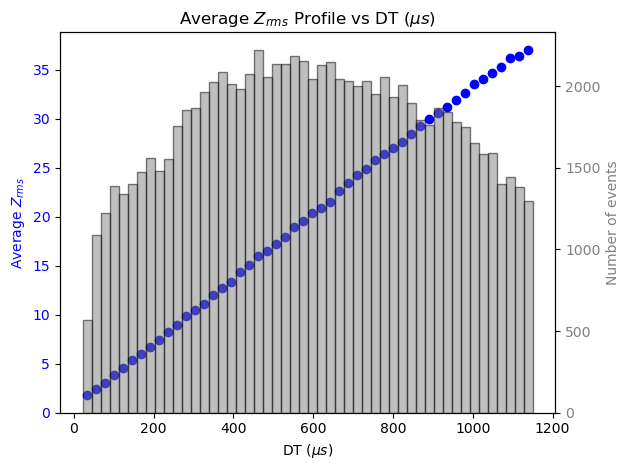

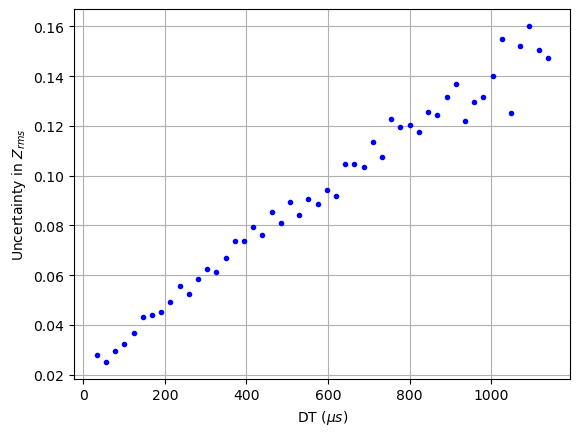

In [42]:
DT_prof, Z_rms_mean_sq, Z_rms_mean_sq_rms = mod.profiles(dst_in1S1['DT'], dst_in1S1['Zrms']**2, threshold=0, x_label=r'DT ($\mu s$)', y_label=r'$Z_{r ms}$',plot=True, normalize=True);

(Nada que ver con nada, pero hice un histograma con la distribución de eventos según el DT y aparece el pico que aparecía al predecir DT con la función de S2w.)

Text(0, 0.5, '# events')

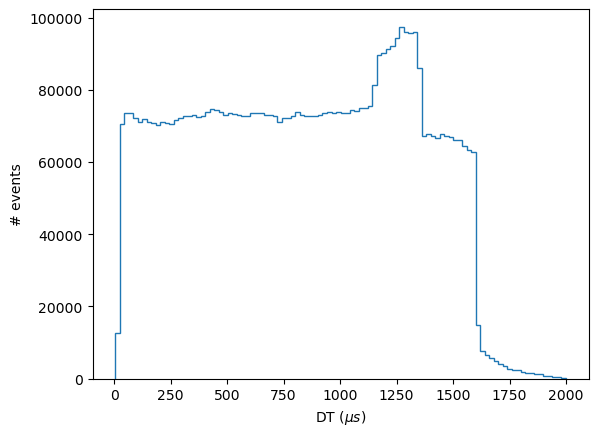

In [44]:
plt.hist(full_data['DT'][full_data['DT']>0], bins=100, histtype='step');
plt.xlabel(r'DT ($\mu s$)');plt.ylabel(r'# events')

In [45]:
drift_velocity=1 # mm/ mu s !!!!!

In [46]:
profile_data_L=mod.Data1d(DT_prof, Z_rms_mean_sq, Z_rms_mean_sq_rms)

In [47]:
def recta(x, a, b):
    return a*x+b

In [48]:
profile_data_L.fit(recta, p0=[0,0]);

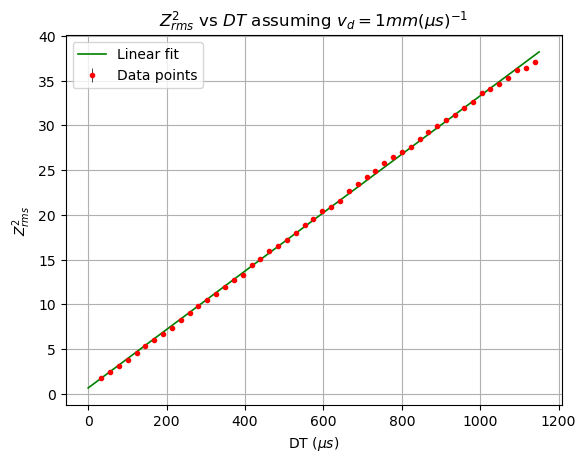

In [49]:
profile_data_L.plot()
plt.plot(np.linspace(0,1150,1000), recta(np.linspace(0,1150,1000), profile_data_L.fit(recta, p0=[0,0])[0][0],
                                        profile_data_L.fit(recta, p0=[0,0])[0][1]), linewidth=1.2, color='green',
                                        label='Linear fit')
plt.xlabel(r'DT ($\mu s)$')
plt.ylabel(r'$Z_{rms}^2$')
plt.title(r'$Z_{rms}^2$ vs $DT$ assuming $v_{d} = 1 mm(\mu s)^{-1}$')
plt.legend()
plt.grid(True)
plt.savefig('Zrms vs DT')

In [50]:
profile_data_L.fit(recta, p0=[0,0])[0][0]

0.03264985954066968

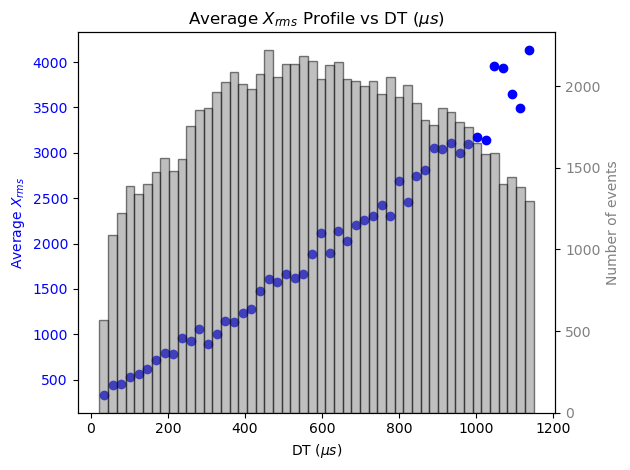

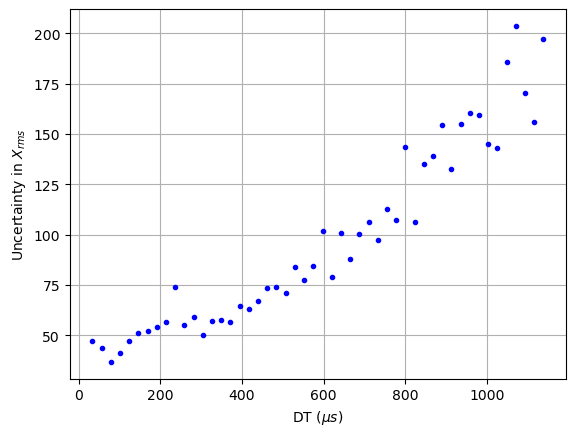

In [51]:
DT_prof, X_rms_mean_sq, X_rms_mean_sq_rms = mod.profiles(dst_in1S1.DT, dst_in1S1.Xrms**2, threshold=0, x_label=r'DT ($\mu s$)', y_label=r'$X_{r ms}$',plot=True,normalize=True);

In [52]:
profile_data_T=mod.Data1d(DT_prof, X_rms_mean_sq, X_rms_mean_sq_rms)

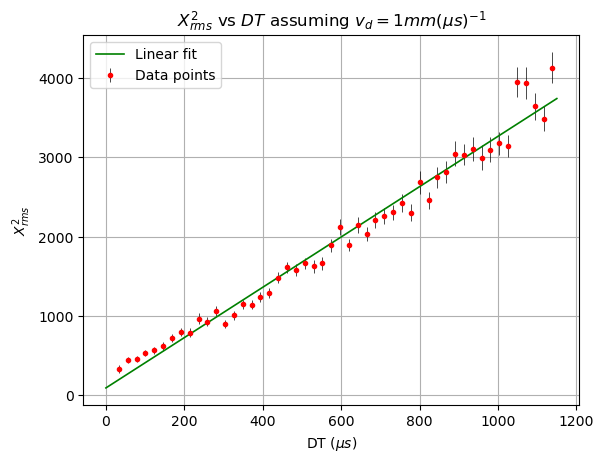

In [53]:
profile_data_T.plot()
plt.plot(np.linspace(0,1150,1000), recta(np.linspace(0,1150,1000), profile_data_T.fit(recta, p0=[0,0])[0][0],
                                        profile_data_T.fit(recta, p0=[0,0])[0][1]), linewidth=1.2, color='green',
                                        label='Linear fit')
plt.xlabel(r'DT ($\mu s)$')
plt.ylabel(r'$X_{rms}^2$')
plt.title(r'$X_{rms}^2$ vs $DT$ assuming $v_{d} = 1 mm(\mu s)^{-1}$')
plt.legend()
plt.grid(True)
plt.savefig('X_rms vs DT')

<Axes: >

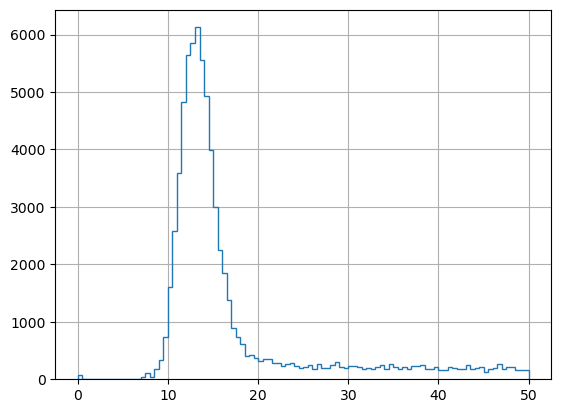

In [106]:
dst_in1S1.Xrms.hist(bins=100, histtype='step', range=(0,50))

In [ ]:
#126.4 V/cm

In [108]:
dst_in1S1.head()

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
80,9,1.734609e+09,13,0,1,1,225.0,1.942003,7.212501,1442125.0,...,11,160.364502,160.364502,1.663571,148.919478,-369.724821,398.589330,-1.187892,10.693094,11.794665
140,72,1.734609e+09,1,0,1,1,150.0,1.630543,6.816255,611000.0,...,17,989.489197,989.489197,5.722768,177.122317,-20.389376,178.292013,-0.114610,15.466112,15.168845
196,107,1.734609e+09,21,0,1,1,175.0,1.499119,6.136397,1544200.0,...,13,58.293251,58.293251,1.392103,-308.007566,-235.591057,387.778038,-2.488632,11.826533,11.709918
359,198,1.734609e+09,6,0,1,1,275.0,1.336479,7.874008,1457825.0,...,15,145.668259,145.668259,2.199228,179.519086,405.992119,443.910693,1.154470,14.888188,12.602237
388,233,1.734609e+09,6,0,1,1,275.0,1.864560,8.546017,469650.0,...,15,1139.834717,1139.834717,5.968433,138.545672,154.099738,207.223629,0.838498,49.949302,14.864375


In [ ]:
#v_d=0.88
#T=25